In [ ]:
from OSCC_postprocessing.cine.functions_videos import *
from pathlib import Path
import json
import os

file = Path(r"G:\Alberth\T85_Schlieren_3.cine")
json_file = Path(r"G:\Alberth\config.json")
out_dir = Path(r"G:\Alberth\Processed_Results")

# Video is in uint12 
video_bits = 12
brightness_levels = 2.0**video_bits

# Load the .cine file into a 3D numpy array (gray scale, shape: (Frame, Height, Width))
video = load_cine_video(file)

# Normalize the grayscale video to [0, 1] brightness range
video /= brightness_levels


F, H, W = video.shape

with open(json_file, 'r', encoding='utf-8') as f:
    # Load metadata
    data = json.load(f)
    number_of_plumes = int(data['plumes'])
    offset = float(data['offset']) # Not used in multi hole (Calculated later by FFT)
    centre = (float(data['centre_x']), float(data['centre_y']))
    ir_ = float(data["inner_radius"])   # inner radius (Injector radius)
    or_ = float(data["outer_radius"])   # outer radius (Quatz window radius)

print(f"The injector has {number_of_plumes} plumes.")
print(f"The nozzle is centred at ({centre[0]:.2f}, {centre[1]:.2f}) in image coordinates.")

Video Info - Width: 768, Height: 768, Frames: 401
The injector has 1 plumes.
The nozzle is centred at (206.00, 98.00) in image coordinates.


In [8]:
from OSCC_postprocessing.playback.video_playback import *
play_video_cv2(video, intv=17)

In [33]:
# Importing libraries
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np

from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.functions_bw import bw_boundaries_all_points
from OSCC_postprocessing.rotation.rotate_crop import generate_CropRect # , generate_plume_mask
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

from OSCC_postprocessing.analysis.single_plume import (
    pre_processing_mie,
)

from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
    rotate_video_nozzle_at_0_half_numpy,
)
warnings.filterwarnings("ignore", category=RuntimeWarning)

global timing
timing = True

if timing:
    import time
import numpy as np
from OSCC_postprocessing.io.async_npz_saver import AsyncNPZSaver
from OSCC_postprocessing.io.async_avi_saver import *
from OSCC_postprocessing.filters.video_filters import *
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.single_plume import (
    USING_CUPY,
    cp,
    _min_max_scale,
    _rotate_align_video_cpu,
    binarize_single_plume_video,
    bw_boundaries_all_points_single_plume,
    bw_boundaries_xband_filter_single_plume,
    filter_schlieren,
    linear_regression_fixed_intercept,
    penetration_bw_to_index,
    pre_processing_mie,
    ransac_fixed_intercept,
    save_boundary_csv,
    to_numpy,
)
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.binarized_metrics import processing_from_binarized_video
import pandas as pd

# Import rotation utility based on backend availability to avoid hard Cupy dependency
if USING_CUPY:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
        rotate_video_nozzle_at_0_half_numpy as rotate_video_nozzle_at_0_half_backend,
    )

def _as_numpy(arr):
    return arr.get() if USING_CUPY else arr


In [31]:
# Check the hardware used for image processing

use_gpu, triangle_backend, xp = resolve_backend(use_gpu="auto", triangle_backend="auto")

print("CUDA is used:", use_gpu)

print("xp represents numpy or cupy? :",xp)

CUDA is used: True
xp represents numpy or cupy? : <module 'cupy' from 'c:\\Users\\Jiang\\Documents\\Mie_Postprocessing_Py\\.venv\\Lib\\site-packages\\cupy\\__init__.py'>


(206.0, 98.0)

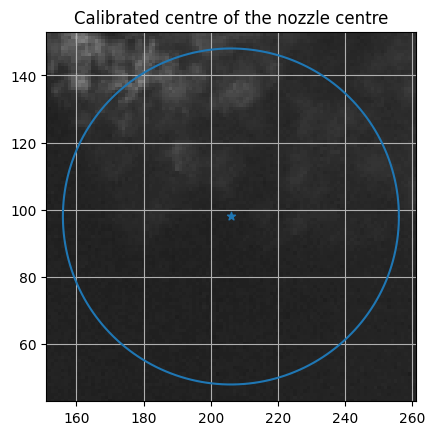

In [57]:
r = 50



# Displaying the clibration
plt.imshow(_as_numpy(video[100])**0.5, cmap="gray")
plt.scatter(centre[0], centre[1], marker="*")

theta = np.linspace(0, 2*np.pi, 400)

x0, y0 = centre[0] , centre[1]

x = x0 + r * np.cos(theta)
y = y0 + r * np.sin(theta)

plt.plot(x, y, linewidth="1.5")
# plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
# plt.show()

plt.xlim([max(0, centre[0]-1.1*r), min(W, centre[0]+1.1*r)])
plt.ylim([max(0, centre[1]-1.1*r), min(H, centre[1]+1.1*r)])
plt.title("Calibrated centre of the nozzle centre")
centre



In [58]:
# Rotation


# Frames, Height, Width
F, H, W = video.shape

# Image rotation settings
INTERPOLATION = "nearest"
BORDER_MODE = "constant"

# Arbitrary rotated image strip shape
OUT_SHAPE = (or_//2, or_)

video = cp.asarray(video)

segment, _, _ = rotate_video_nozzle_at_0_half_backend(
        video,
        centre, # (nozzle_x, nozzle_y) # change to centre_x + cos(angle) * r, centre_y + sin(angle) * r
        # (centre[0] + np.cos(angle/180.0*np.pi) * ir_, centre[1] + np.sin(angle/180.0*np.pi) * ir_),
        offset,
        interpolation=INTERPOLATION,
        border_mode=BORDER_MODE,
        out_shape=OUT_SHAPE,
    )

segment = _min_max_scale(segment)

In [59]:
play_video_cv2(segment.get(), intv=17)

In [60]:
td_map = xp.sum(segment, axis=1).T

Text(0, 0.5, 'pixels')

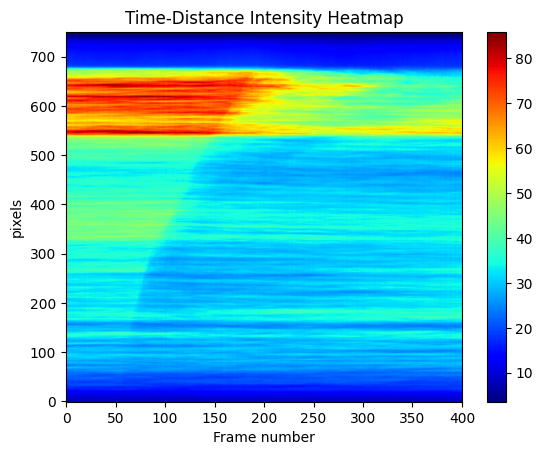

In [61]:
plt.imshow(td_map.get(), origin="lower", aspect="auto", cmap="jet")
plt.title("Time-Distance Intensity Heatmap")
plt.colorbar()
plt.xlabel("Frame number")
plt.ylabel("pixels")

Text(0, 0.5, 'pixels')

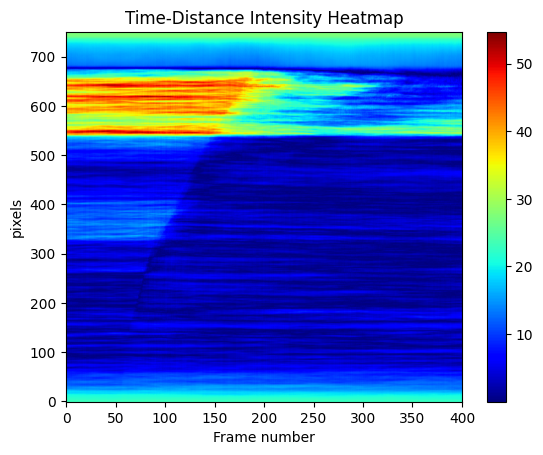

In [62]:
plt.imshow(np.abs(td_map.get() - np.median(td_map.get())), origin="lower", aspect="auto", cmap="jet")
plt.title("Time-Distance Intensity Heatmap")
plt.colorbar()
plt.xlabel("Frame number")
plt.ylabel("pixels")

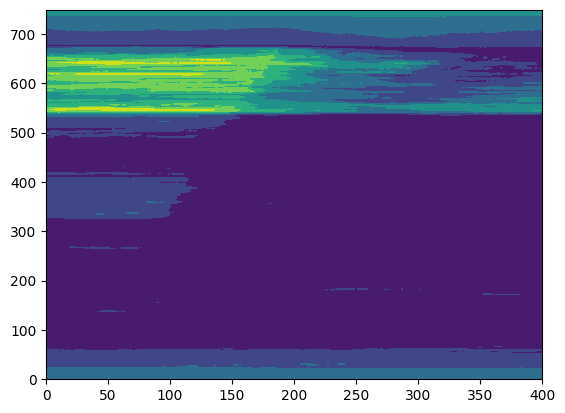

In [63]:
plt.contourf(np.abs(td_map.get() - np.median(td_map.get())))

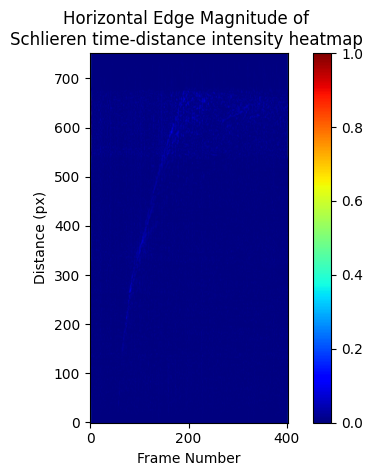

In [64]:
map = np.abs(td_map.get() - np.median(td_map.get()))


import scipy
kernel = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
])
edge_magnitude_horizontal = scipy.signal.convolve2d(map, kernel)

# edge_magnitude_vertical = scipy.signal.convolve2d(map, kernel.T)
normalized_magnitude_map = _min_max_scale(np.abs(edge_magnitude_horizontal))

plt.imshow(normalized_magnitude_map, origin="lower", cmap="jet")
plt.title("Horizontal Edge Magnitude of \nSchlieren time-distance intensity heatmap ")

plt.xlabel("Frame Number")
plt.ylabel("Distance (px)")

plt.colorbar()

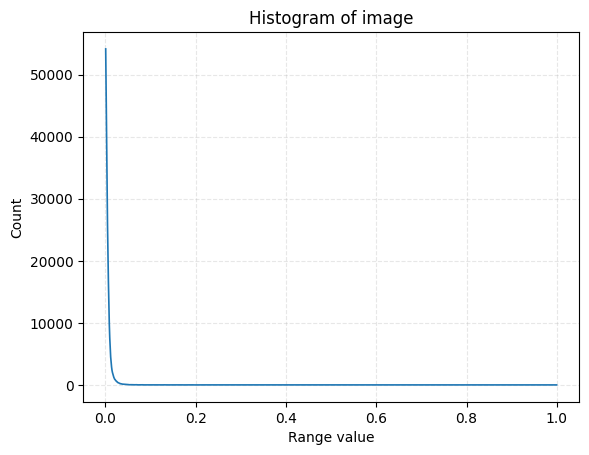

In [65]:
imhist(_min_max_scale(np.abs(edge_magnitude_horizontal)))

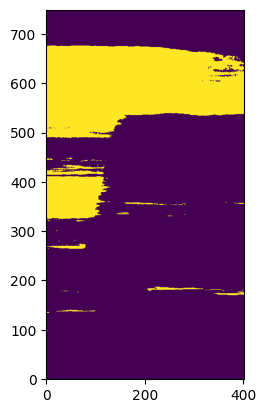

In [66]:
from OSCC_postprocessing.analysis.single_plume import *
from OSCC_postprocessing.binary_ops.functions_bw import *
 


bw = _min_max_scale(td_map) > 0.41 # triangle_binarize_gpu(_min_max_scale(td_map))

plt.imshow(bw.get(), origin="lower")
                

In [67]:
def to_numpy(arr):
    return cp.asnumpy(arr) if USING_CUPY else np.asarray(arr)

In [68]:
from OSCC_postprocessing.io import * 
from pathlib import Path
npz_saver = AsyncNPZSaver(max_workers=2)
avi_saver = AsyncAVISaver(max_workers=2)

save_name_stem = Path(file).stem

Path(out_dir/"Rotated_Videos").mkdir(parents= True, exist_ok=True)
Path(out_dir / "Postprocessed_Data").mkdir(parents=True, exist_ok=True)

save_path_video = out_dir / "Rotated_Videos"
save_path_data = out_dir / "Postprocessed_Data"

# Save the Foreground video asynchronously
avi_saver.save(save_path_video / (save_name_stem + ".avi"), to_numpy(segment), is_color=False)
               
npz_saver.save(save_path_video / (save_name_stem + ".npz"), segment=to_numpy(segment))


<Future at 0x2337c48aba0 state=running>

In [ ]:
from OSCC_postprocessing.filters.svd_background_removal import * 

svd_segment = svd_foreground_cuda(segment, rank=10, bkg_frame_limit=20, center="mean")

svd_negative = svd_segment.copy()
svd_negative[svd_negative > 0] = 0

scaled_svd_segment = _min_max_scale(-svd_negative)



In [112]:
play_video_cv2(scaled_svd_segment.get()*10.0, intv=17)



In [116]:
ranks = [1, 2, 3, 4, 5]

for rank in ranks:
    svd_segment = svd_foreground_cuda(segment, rank=rank, bkg_frame_limit=20, center="mean")
    svd_negative = svd_segment.copy()
    svd_negative[svd_negative > 0] = 0
    scaled_svd_segment = _min_max_scale(-svd_negative)
    play_video_cv2(scaled_svd_segment.get()*10.0, intv=17)



Text(0, 0.5, 'pixels')

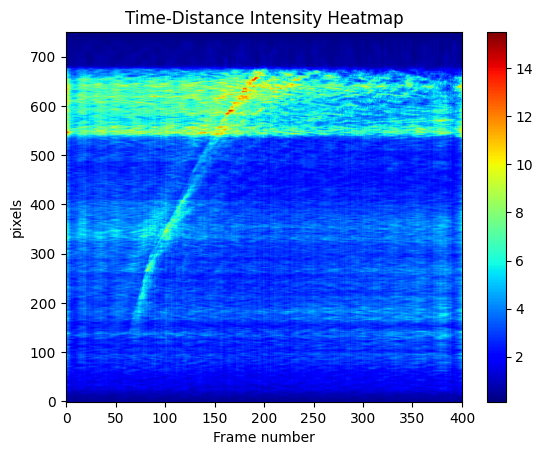

In [104]:
td_map = xp.sum(scaled_svd_segment, axis=1).T
plt.imshow(td_map.get(), origin="lower", aspect="auto", cmap="jet")
plt.title("Time-Distance Intensity Heatmap")
plt.colorbar()
plt.xlabel("Frame number")
plt.ylabel("pixels")

In [107]:
cat_vids = np.concatenate([to_numpy(segment), to_numpy(np.clip(5.0*scaled_svd_segment, 0, 1))], axis=1)

play_video_cv2(cat_vids, intv=17)

In [108]:
avi_saver.save(save_path_video / (save_name_stem + "_svd_foreground.avi"), to_numpy(cat_vids), is_color=False)

<Future at 0x22f9e35bfe0 state=pending>

In [134]:
import cupy as cp
import numpy as np

def dmd_foreground_cuda(
    video_FHW: cp.ndarray,
    rank: int = 10,
    freq_threshold: float = 0.1,
    return_bg: bool = False,
    dt: float = 1.0
) -> cp.ndarray | tuple[cp.ndarray, cp.ndarray]:
    """
    DMD 去除动态背景 (修正了 reshape 类型报错与 eig 兼容性问题)。
    """
    F, H, W = video_FHW.shape
    
    # --- 关键修正：强制转为 Python 原生 int，防止 reshape 报错 ---
    F, H, W = int(F), int(H), int(W)
    
    # 1. 准备数据矩阵
    flat_video = video_FHW.reshape(F, -1).T  # (HW, F)
    X = flat_video[:, :-1] 
    Y = flat_video[:, 1:] 

    # 2. SVD (GPU)
    # 计算量最大的一步，保持在 GPU
    U, s, Vt = cp.linalg.svd(X, full_matrices=False)
    
    r = min(rank, s.size)
    Ur = U[:, :r]
    sr = s[:r]
    Vr = Vt[:r, :] 
    
    # 3. 计算近似线性算子 A_tilde (GPU)
    sr_inv = cp.reciprocal(sr)
    A_tilde = (Ur.conj().T @ Y) @ (Vr.conj().T * sr_inv[None, :]) 

    # 4. 特征分解 (混合计算 CPU)
    # 这里的 A_tilde 很小 (如 20x20)，传回 CPU 计算更稳，且避开 cupy.linalg.eig 缺失问题
    A_tilde_cpu = cp.asnumpy(A_tilde)
    lambda_vals_cpu, W_cpu = np.linalg.eig(A_tilde_cpu)
    
    # 将结果转回 GPU
    lambda_vals = cp.asarray(lambda_vals_cpu)
    W = cp.asarray(W_cpu)

    # 5. 计算 DMD 模态 Phi (GPU)
    Phi = Y @ (Vr.conj().T * sr_inv[None, :]) @ W

    # 6. 计算模态振幅 b (GPU)
    x0 = X[:, 0]
    b = cp.linalg.pinv(Phi) @ x0

    # 7. 频率分析 (GPU)
    log_lambda = cp.log(lambda_vals)
    omega = log_lambda / dt
    freqs = cp.abs(omega.imag) / (2 * cp.pi)

    # 8. 背景分离逻辑
    bg_indices = freqs < freq_threshold
    
    # 兜底：如果没选出背景，强制选最慢的一个
    if not cp.any(bg_indices):
        bg_indices[cp.argmin(freqs)] = True

    # 9. 重构背景 (GPU)
    Phi_bg = Phi[:, bg_indices]
    b_bg = b[bg_indices]
    lambda_bg = lambda_vals[bg_indices]
    
    time_steps = cp.arange(F)
    # 广播计算时间序列
    V_time = cp.power(lambda_bg[:, None], time_steps[None, :])
    
    bg_flat_complex = (Phi_bg * b_bg[None, :]) @ V_time
    bg_flat = bg_flat_complex.real 
    
    # 10. 输出 (此处已修正 reshape 类型问题)
    # bg_flat.T 形状为 (F, HW)，reshape 为 (F, H, W)
    bg_FHW = bg_flat.T.reshape(video_FHW.shape)
    
    # 此时数据可能为 float64，如果原视频是 uint8，建议根据需求转换，这里保持精度
    fg_FHW = video_FHW - bg_FHW

    if return_bg:
        return fg_FHW, bg_FHW
    return fg_FHW

In [148]:

# --- 使用示例 ---
# 假设 video_gpu 是一个 (100, 512, 512) 的 cupy array
fg, bg = dmd_foreground_cuda(segment, rank=10, freq_threshold=0.05, return_bg=True)

In [153]:
fg_pos = fg.copy()
fg_pos[fg_pos < 0] = 0
fg_neg = fg.copy()
fg_neg[fg_neg > 0] = 0


In [138]:
play_video_cv2(fg.get(), intv=17)

In [156]:
cat_vids = np.concatenate([to_numpy(segment), 
            to_numpy(np.clip(-5.0*fg_neg, 0, 1)),
            to_numpy(np.clip(5.0*fg_pos, 0, 1))
            ], axis=1)

play_video_cv2(cat_vids, intv=17)

In [157]:
avi_saver.save(save_path_video / (save_name_stem + "_svd_foreground.avi"), to_numpy(cat_vids), is_color=False)

<Future at 0x22f9c789d30 state=pending>